In [1]:
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv(r"/Users/shilpa/Downloads/QQQ_whole_ET - QQQ_whole_ET.csv") 
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
data=df
# Function to calculate higher highs (HH), higher lows (HL), lower lows (LL), and lower highs (LH)
def find_high_low(data, window):
    data['HH'] = data['High'].rolling(window=window, center=False).max().shift(-window)
    data['HL'] = data['Low'].rolling(window=window, center=False).min().shift(-window)
    data['LL'] = data['Low'].rolling(window=window, center=False).min().shift(-window)
    data['LH'] = data['High'].rolling(window=window, center=False).max().shift(-window)
    return data

# Applying the function to the DataFrame
window = 5
df = find_high_low(df, window)

# Prepare the data for training
features = df[['Open', 'High', 'Low', 'Close']].values
labels = df[['HH', 'HL', 'LL', 'LH']].values

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(0.8 * len(features))
train_features, test_features = features[:train_size], features[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Standardize the data for better convergence
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalAveragePooling1D
from keras.activations import softmax
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Bidirectional, TimeDistributed


from keras.utils import to_categorical

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# One-hot encode the labels
labels_encoded = np.argmax(labels, axis=1)
labels_one_hot = to_categorical(labels_encoded, num_classes=4)  # Specify the number of classes (4)

# Assuming `features` contains the entire dataset
# Reshape the features to include a time sequence and channel dimension for LSTM layer
sequence_length = 5
num_features = 4
train_size = int(0.8 * len(features))
train_sequences = [features[i:i+sequence_length] for i in range(train_size - sequence_length + 1)]
train_sequences = np.array(train_sequences)
train_labels = labels_one_hot[sequence_length-1:train_size]

test_sequences = [features[i:i+sequence_length] for i in range(train_size, len(features) - sequence_length + 1)]
test_sequences = np.array(test_sequences)
test_labels = labels_one_hot[train_size + sequence_length - 1:]

# Updated deep learning model with LSTM
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True), input_shape=(sequence_length, num_features)))
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate and learning rate scheduling
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Apply early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)

# Train the updated model with early stopping and learning rate scheduling
model.fit(train_sequences, train_labels, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the updated model on the test data
loss = model.evaluate(test_sequences, test_labels, verbose=0)
print('Test Loss:', loss)

Epoch 1/100
1961/1961 [==============================] - 7s 3ms/step - loss: 0.0786 - val_loss: 0.0031 - lr: 0.0010
Epoch 2/100
1961/1961 [==============================] - 6s 3ms/step - loss: 0.0013 - val_loss: 8.1978e-04 - lr: 0.0010
Epoch 3/100
1961/1961 [==============================] - 6s 3ms/step - loss: 0.0012 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/100
1961/1961 [==============================] - 6s 3ms/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0010
Epoch 5/100
1953/1961 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1961/1961 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 8.1584e-04 - lr: 0.0010
Epoch 6/100
1961/1961 [==============================] - 6s 3ms/step - loss: 7.6433e-04 - val_loss: 6.3356e-04 - lr: 5.0000e-04
Epoch 7/100
1961/1961 [==============================] - 6s 3ms/step - loss: 5.3601e-04 - val_loss: 4.7144e-04 - lr: 5.0000e-04
Epoch 8/100


In [ ]:
# Tried testing the model with different layers, model parameters such as bach size, regularizations, activation functions. Seems like more data can be usefull for better generalization. The model seems to overfit sometimes.

In [3]:
print("Training Data Shape:", train_sequences.shape)
print("Training Label Shape:", train_labels.shape)


print("Model Summary:")
print(model.summary())

Training Data Shape: (78408, 5, 4)
Training Label Shape: (78408, 4)
Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 64)             9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)

In [8]:
## Performing version 2

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sample data (replace with your own data)

# Convert the sample data to a DataFrame
df = pd.read_csv(r"/Users/shilpa/Downloads/QQQ_whole_ET - QQQ_whole_ET.csv") 

# Generate synthetic labels based on the given data
# Assume that HH is True when Close > High of the next bar, and LL is True when Close < Low of the next bar
df['Next_High'] = df['High'].shift(-1)
df['Next_Low'] = df['Low'].shift(-1)
df['HH'] = df['Close'] > df['Next_High']
df['LL'] = df['Close'] < df['Next_Low']

# Combine HH and LL labels to create a binary classification problem
df['Label'] = np.where(df['HH'] | df['LL'], 1, 0)

# Drop unnecessary columns
df = df.drop(['Next_High', 'Next_Low', 'HH', 'LL'], axis=1)

# Load and preprocess the data
features = df[['Open', 'High', 'Low', 'Close']].values
labels = df['Label'].values

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Shift the target labels 1 bar ahead to create the desired time lag
lag = 5  # 5-bar lag
shifted_labels = np.roll(labels, -lag)

# Filter the data to keep only instances where the current label is 1 (True)
filtered_indices = np.where(labels == 1)[0]
filtered_features = features[filtered_indices]
filtered_labels = shifted_labels[filtered_indices]

# Create the time sequences for training and testing
sequence_length = 5
train_size = int(0.8 * len(filtered_features))
train_sequences = [filtered_features[i:i+sequence_length] for i in range(train_size - sequence_length + 1)]
train_sequences = np.array(train_sequences)
train_labels = filtered_labels[sequence_length-1:train_size]

test_sequences = [filtered_features[i:i+sequence_length] for i in range(train_size, len(filtered_features) - sequence_length + 1)]
test_sequences = np.array(test_sequences)
test_labels = filtered_labels[train_size + sequence_length - 1:]

# Updated deep learning model with LSTM and increased dropout
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True), input_shape=(sequence_length, 4)))
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification

# Compile the model with a lower learning rate and learning rate scheduling
optimizer = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Apply early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)

# Train the updated model with early stopping and learning rate scheduling
model.fit(train_sequences, train_labels, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the updated model on the test data
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Epoch 1/100
139/139 [==============================] - 2s 4ms/step - loss: 0.4180 - accuracy: 0.9004 - val_loss: 0.2401 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 2/100
139/139 [==============================] - 0s 3ms/step - loss: 0.3198 - accuracy: 0.9185 - val_loss: 0.2406 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 3/100
139/139 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.9185 - val_loss: 0.2477 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 4/100
133/139 [===========================>..] - ETA: 0s - loss: 0.3061 - accuracy: 0.9175
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
139/139 [==============================] - 0s 3ms/step - loss: 0.3036 - accuracy: 0.9185 - val_loss: 0.2401 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 5/100
139/139 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.9185 - val_loss: 0.2414 - val_accuracy: 0.9367 - lr: 5.0000e-04
Epoch 6/100
139/139 [==============================] - 

44/44 [==============================] - 0s 755us/step


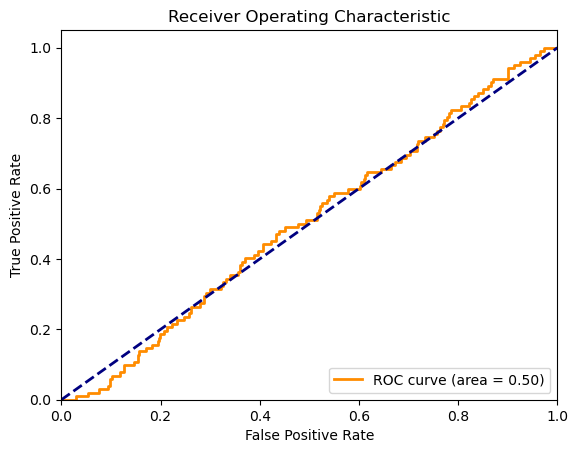

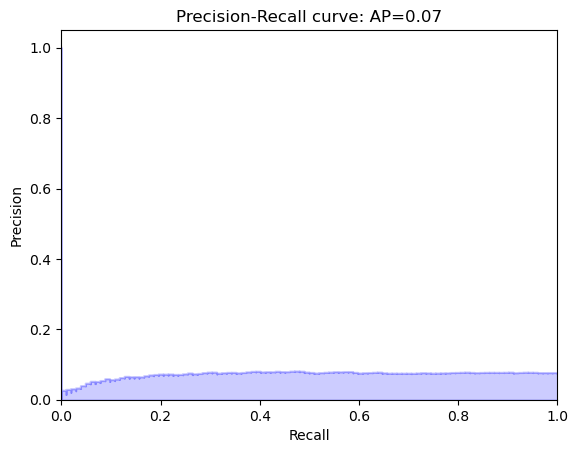

Confusion Matrix:
[[1277    0]
 [ 102    0]]


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

# Plot performance graphs
def plot_performance(y_true, y_pred_probs):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    average_precision = average_precision_score(y_true, y_pred_probs)
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f}'.format(average_precision))
    plt.show()

# Predict on the test data and plot performance graphs
y_pred_probs = model.predict(test_sequences).flatten()
y_pred_binary = (y_pred_probs >= 0.5).astype(int)
plot_performance(test_labels, y_pred_probs)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)

In [3]:
print("Training Data Shape:", train_sequences.shape)
print("Training Label Shape:", train_labels.shape)

print("Model Summary:")
print(model.summary())

Training Data Shape: (5524, 5, 4)
Training Label Shape: (5524,)
Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 64)             9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)    

In [ ]:
""" Analysis on the overall performance

True Positives (TP): 0
True Negatives (TN): 1277
False Positives (FP): 0
False Negatives (FN): 102
The confusion matrix shows that the model correctly predicted 1277 samples of the "negative" class (class 0) as true negatives (TN) 
and did not make any false positive (FP) predictions for the "positive" class (class 1). 
However, it also shows that the model did not predict any true positives (TP) and made 102 false negatives (FN) predictions for the 
"positive" class.

Test Loss: 0.2651948630809784
Test Accuracy: 0.9260333776473999
    
* Test Loss is the value of the loss function (e.g., cross-entropy) calculated on the test data. In this case, it has a value of 
approximately 0.265, indicating a reasonably low loss value.
* Test Accuracy is the proportion of correctly classified samples in the test dataset. It has a value of approximately 0.926, 
indicating that the model correctly classified around 92.6% of the test samples.

Interpretation:

The model seems to perform quite well in terms of overall accuracy (92.6%), 
but it struggles to predict the positive class ("1" or HH, HL, LL, LH). 
This issue can be due to class imbalance, where one class (negative) 
significantly outnumbers the other class (positive) in the dataset. 
The model might be biased towards predicting the majority class, 
leading to good accuracy but poor performance on the minority class.

To improve the model's performance, consider the following steps:

1. Address Class Imbalance: If class imbalance is present, consider techniques like oversampling, undersampling, 
or using class weights during training to give more importance to the minority class.
2. Adjust Decision Threshold: The default decision threshold for binary classification is usually 0.5. 
However, adjusting the threshold might help balance precision and recall for the positive class. 
You can use metrics like precision, recall, and F1-score to optimize the threshold.
3. Explore Other Models: Experiment with different architectures or models like SVM, random forest, or gradient boosting, 
and see if they offer better performance for this specific task.
4. Feature Engineering: Analyze and explore other features that could provide more discriminative power 
for distinguishing between the classes.
5. Cross-Validation: Perform cross-validation to get a better understanding of the model's 
performance on different subsets of the data.

""""